In [12]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import random_split
# Torchvision
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


In [3]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.RandomErasing(0.4),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

In [8]:
dataset = torchvision.datasets.ImageFolder("./trafic_32/trafic_32/", transform=transform)
dataloader =torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
dataset[0][0].size()

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
trainset, valset = random_split(dataset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)

# testset = torchvision.datasets.ImageFolder("./test_all/", transform=transform)
# testloader =torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [22]:
def get_train_images(num):
    return torch.stack([valset[i][0] for i in range(10,10+num)], dim=0)

In [26]:
image, _ = dataset[0]
print(image.size())

torch.Size([3, 32, 32])


In [ ]:
classes = dataset.classes
classes

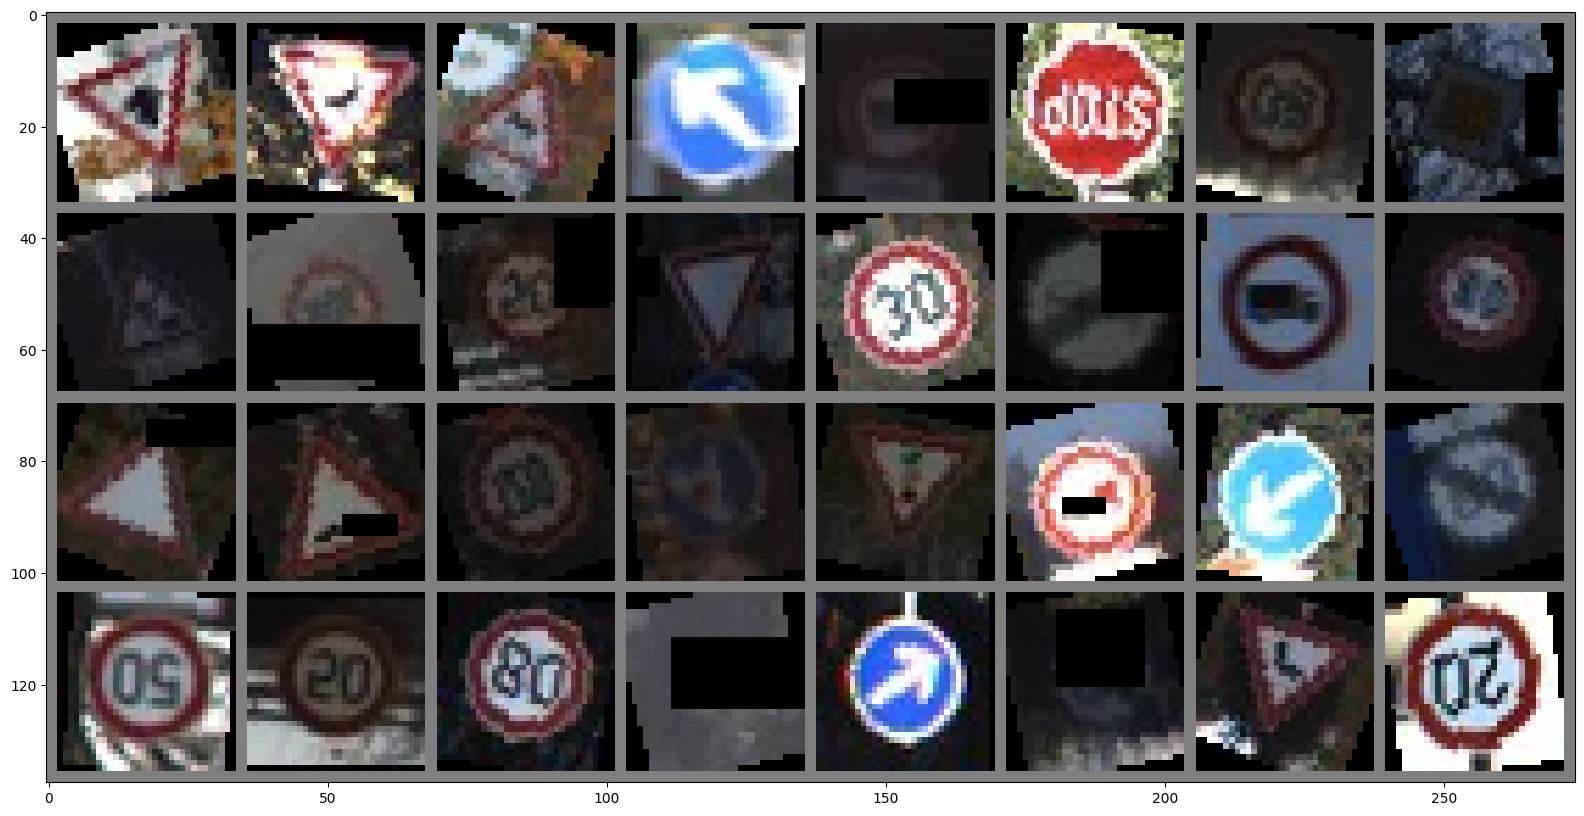

00011 00019 00023 00039 00016 00014 00005 00012 00025 00007 00002 00013 00001 00041 00016 00005 00013 00022 00008 00036 00026 00010 00038 00006 00002 00002 00005 00012 00038 00006 00019 00000


In [13]:
plt.figure(figsize = (20,10))

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Sieć VAE

In [36]:
class Encoder(nn.Module):
    def __init__(self, input_channels, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc_mean = nn.Linear(256 * 2 * 2, latent_dim)
        self.fc_var = nn.Linear(256 * 2 * 2, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.LeakyReLU(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.LeakyReLU(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        
        x = self.LeakyReLU(self.conv3(x))
        x = self.bn3(x)
        x = self.pool3(x)
        
        x = self.LeakyReLU(self.conv4(x))
        x = self.bn4(x)
        x = self.pool4(x)
        
        x = x.view(x.size(0), -1)
        
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)
        
        return mean, log_var


In [37]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_channels):
        super(Decoder, self).__init__()

        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, 256 * 2 * 2)
        
        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.deconv4 = nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1)
        
        self.leakyrelu = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.leakyrelu(self.fc_1(x))
        x = self.leakyrelu(self.fc_2(x))
        x = self.leakyrelu(self.fc_3(x))
        
        x = x.view(x.size(0), 256, 2, 2)  # Przywrócenie kształtu tensora po spłaszczeniu
        
        x = self.leakyrelu(self.deconv1(x))
        x = self.bn1(x)
        
        x = self.leakyrelu(self.deconv2(x))
        x = self.bn2(x)
        
        x = self.leakyrelu(self.deconv3(x))
        x = self.bn3(x)
        
        x = torch.sigmoid(self.deconv4(x))
        
        return x


In [38]:
class VAE(nn.Module):
    def __init__(self, input_channels, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_channels=input_channels, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_channels=input_channels)

    def reparameterization(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var


Trening VAE

In [39]:
vae = VAE(input_channels=3, hidden_dim=256, latent_dim=16).to(device)

In [40]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD      = -0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [41]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [42]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()
    
    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [55]:
num_epochs = 10
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(trainloader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var) 
        losses_epoch.append(loss.item())
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()  
    L1_list = []
#     if n % 10 == 0:
    for x, _ in iter(valloader):
        x  = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out-x)).item())
    print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
    scheduler.step()

Epoch 0 loss 48544.82546409117, test L1 = 0.6296781709766001
Epoch 1 loss 47984.68269981205, test L1 = 0.6267643139614323
Epoch 2 loss 47766.66685182531, test L1 = 0.621826515449741
Epoch 3 loss 47431.4817807881, test L1 = 0.6191022800720805
Epoch 4 loss 47274.88193598289, test L1 = 0.6206834333214334
Epoch 5 loss 47212.33996519814, test L1 = 0.6149483728941864
Epoch 6 loss 47153.44877775389, test L1 = 0.6175057529433956
Epoch 7 loss 47147.65412565303, test L1 = 0.6162455925127355
Epoch 8 loss 47033.242074015674, test L1 = 0.6152339216654863
Epoch 9 loss 47012.458641931065, test L1 = 0.6142114333020963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


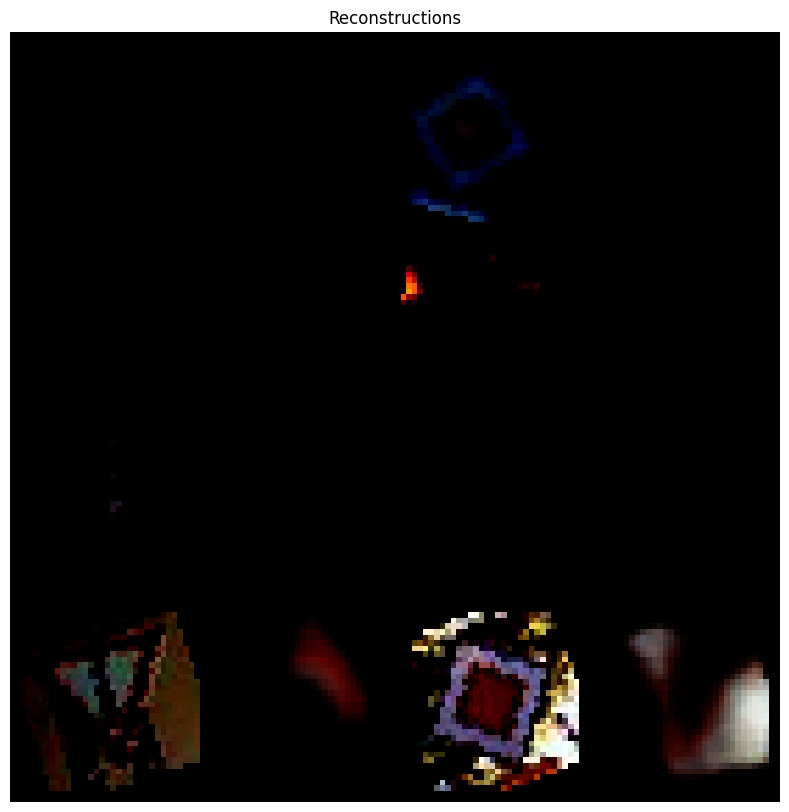

In [56]:
input_imgs = get_train_images(8)
visualize_reconstructions(vae, input_imgs, device)

In [57]:
def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()
    
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10,10))
    else:
        plt.figure(figsize=(15,10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

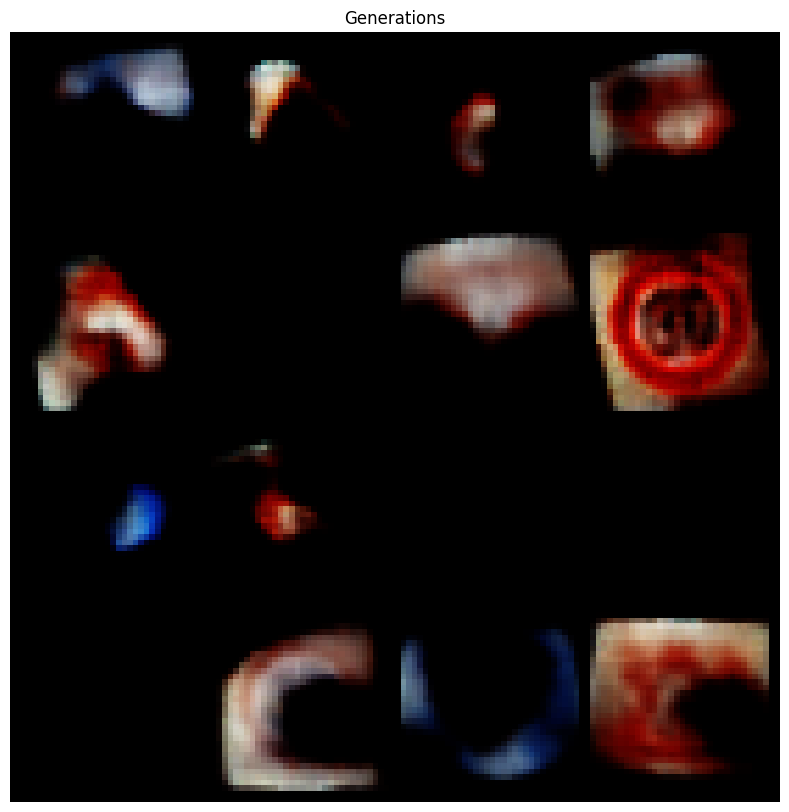

In [58]:
generate_images(vae, 16, device)

Ewaluacja

In [49]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [50]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out  = nn.Linear(50, 10)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x
    

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x

evaluator = Evaluator(28*28, 256).to(device)

In [51]:
latent_dim = 16

with torch.no_grad():
    fixed_noise = torch.randn(1000, latent_dim, device=device)
    fixed_labels = torch.randint(10,(1000,),device=device)
    fixed_labels = F.one_hot(fixed_labels, 10).float()
#     generations_cond_gan = cond_generator(fixed_noise, fixed_labels)
    # generations_gan = generator(fixed_noise)
    generations_vae = vae.decoder(fixed_noise)

In [52]:
orig_data = [x[0] for x in list(valset)[:1000]]
orig_data = torch.cat(orig_data)

In [59]:
with torch.no_grad():
    dist_orig_data = evaluator.get_features(orig_data.to(device)).cpu()
    dist_vae = evaluator.get_features(generations_vae.to(device)).cpu()
    # dist_gan = evaluator.get_features(generations_gan.to(device)).cpu()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3000x1024 and 784x256)

In [54]:
orig_data_2 = [x[0] for x in list(valset)[-1000:]]
orig_data_2 = torch.cat(orig_data_2)
with torch.no_grad():
    dist_orig_data_2 = evaluator.get_features(orig_data_2.to(device)).cpu()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3000x1024 and 784x256)

In [ ]:
for name, obj in zip(['orig','vae'],[dist_orig_data_2.numpy(),dist_vae.numpy()]):
    print(f"FD {name}: {calculate_frechet_distance(dist_orig_data.numpy(),obj)}")